# Au verification: multislice vs WPM vs ODE

Thicknes sweep for Au comparing abTEM multislice, WPM, and an adaptive ODE integrator.

In [1]:
%matplotlib widget

import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".4"

import abtem
from scipy.interpolate import interp1d

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from ase.build import bulk
from tqdm.auto import tqdm

from wide_angle_propagation import (
    electron_refractive_index,
    energy2wavelength,
    simulate_fresnel_as,
    simulate_wpm,
    fresnel_propagation_kernel,
    get_abtem_transmit
)

abtem.config.set({"device": "cpu"})
abtem.config.set({"precision": "float64"})
jax.config.update("jax_enable_x64", True)


def beam_amplitude_normalized(psi_xy, h, k, use_fftshift=True):
    Ny, Nx = psi_xy.shape

    # normalized Fourier coefficients so that a unit plane wave has C00 = 1
    C = jnp.fft.fft2(psi_xy) / (Nx * Ny)

    if use_fftshift:
        C = jnp.fft.fftshift(C)
        cy, cx = Ny // 2, Nx // 2
        return jnp.abs(C[cy + k, cx + h])   # [h,k] beam
    else:
        # unshifted indexing: negative orders wrap around
        return jnp.abs(C[k % Ny, h % Nx])

Extracted data from Klein-Gordon equation solutions for both diagrams a and b of figure 3 in doi:10.1016/j.ultramic.2008.08.008

In [2]:

# Extracted Plot data:

raw_data_Au_Beam_0_0_Klein_Gordon_MS = """0.06421232876712413, 0.9984732824427482
0.98458904109589, 0.9874045801526719
1.9049657534246576, 0.9599236641221375
2.397260273972603, 0.9431297709923665
3.4460616438356153, 0.9041984732824428
4.216609589041096, 0.8809160305343512
4.880136986301369, 0.867557251908397
5.736301369863013, 0.8641221374045802
6.6138698630137, 0.8725190839694656
7.4486301369863, 0.8858778625954199
8.197773972602743, 0.9022900763358779
8.94691780821918, 0.918320610687023
9.76027397260274, 0.9286259541984734
10.637842465753426, 0.9324427480916031
11.665239726027401, 0.9240458015267177
12.671232876712331, 0.9041984732824428
13.613013698630137, 0.8809160305343513
14.511986301369863, 0.8595419847328245
15.325342465753433, 0.8450381679389314
16.438356164383563, 0.835496183206107
17.529965753424662, 0.8381679389312977
18.728595890410965, 0.8461832061068704
19.58476027397261, 0.8515267175572521
20.71917808219178, 0.8530534351145038
21.72517123287672, 0.8473282442748091
23.073630136986306, 0.8297709923664123
24.14383561643836, 0.8118320610687024
24.807363013698637, 0.8030534351145039

"""


raw_data_Au_Beam_0_28_Klein_Gordon_FWD = """0.22062721060899548, 0.00022950819672130918
0.7942772332571906, 0.000852459016393449
1.500467420321705, 0.0018360655737704942
2.339342334788604, 0.0033770491803278707
3.0016335617428496, 0.004622950819672133
4.680202580931187, 0.008819672131147538
5.828562754792266, 0.011508196721311474
7.373218261196406, 0.013475409836065575
8.475824249959047, 0.013901639344262293
9.798479197386307, 0.013770491803278686
10.768593209394673, 0.013901639344262293
11.915700504042945, 0.014885245901639345
12.908872312333159, 0.01639344262295082
14.41020711057142, 0.01940983606557377
15.05035610682242, 0.020524590163934424
16.373974807490292, 0.02170491803278688
18.093647902391076, 0.02183606557377049
19.32792667765346, 0.02144262295081967
21.35669953065218, 0.02219672131147541
22.901379130887335, 0.024196721311475405
24.0047802160735, 0.02570491803278688
24.93111573712666, 0.02626229508196721"""


raw_data_Au_Beam_0_28_Klein_Gordon_MS = """0.06620984763060989, 0.00009836065573769898
0.8162989948053649, 0.0008196721311475447
1.478421564942515, 0.0018360655737704873
2.9133055772400027, 0.0044262295081967246
5.253876697410391, 0.009475409836065572
6.732466919170015, 0.011540983606557375
8.12178949701719, 0.012131147540983607
9.796937192201312, 0.011672131147540982
11.870355914071766, 0.013180327868852457
13.613857807846884, 0.015737704918032787
14.606836865488965, 0.016983606557377046
15.841790268019778, 0.017508196721311473
16.76733069264946, 0.016983606557377046
18.177205308352853, 0.015540983606557375
19.939813610123274, 0.014098360655737704
22.034724029259564, 0.01485245901639344
23.071144264222596, 0.015213114754098356
24.085157236341217, 0.015081967213114753
24.92234558263702, 0.014327868852459017
"""

def parse_and_interpolate(raw_data):
    # Parse the comma-separated data
    data = np.array([[float(val) for val in line.split(',')] for line in raw_data.strip().split('\n')])
    
    # Sort by the first column (x)
    data = data[data[:, 0].argsort()]
    
    x_extracted = data[:, 0]
    y_extracted = data[:, 1]

    # Create cubic interpolator
    return interp1d(x_extracted, y_extracted, kind='linear', fill_value="extrapolate")

Beam_0_0_Au_Klein_Gordon_MS = parse_and_interpolate(raw_data_Au_Beam_0_0_Klein_Gordon_MS)
Beam_0_28_Au_Klein_Gordon_FWD = parse_and_interpolate(raw_data_Au_Beam_0_28_Klein_Gordon_FWD)
Beam_0_28_Au_Klein_Gordon_MS = parse_and_interpolate(raw_data_Au_Beam_0_28_Klein_Gordon_MS)


## Crystal and beam setup

In [3]:
atoms = bulk("Au", "fcc", a=4.08, cubic=True)
coarse_unitcell_gpts = (128, 128, 2)
energy = 300e3
n_cells_range = range(0, 26)

# For FCC cubic cell, there are 2 atomic planes in the z-direction.
# We want 1 slice per atomic plane.
n_slices_coarse = 2 

cell_thickness = atoms.get_cell()[2, 2]
slice_thickness_coarse = cell_thickness / 2

atoms.info['thermal_sigma'] = 0.0
atoms.arrays['thermal_sigma'] = np.zeros(len(atoms))

potential_lobato = abtem.Potential(
    atoms,
    gpts=coarse_unitcell_gpts[:2],
    slice_thickness=slice_thickness_coarse,
    projection="infinite",
    parametrization="lobato"
)

In [4]:
import numpy as np
import abtem
from abtem.parametrizations import Parametrization
from ase.build import bulk

# 1. Define the Math Function with Unit Conversion
def weickenmeier_kohl_function(k2, parameters):
    """
    Evaluates the scattering potential V(k) by converting the 
    elastic scattering factor f(s).
    
    Formula: V(k) = 47.878 * f(s)
    Ref: Acta Cryst. (1991). A47, 590-597.
    """
    A, B = parameters
    
    # abTEM k is spatial frequency (1/d). Paper s = k/2.
    s2 = k2 / 4.0
    
    # 1. Calculate f(s) [Angstroms]
    # Expand s2 for broadcasting: (N_pixels, 1)
    s2_expanded = s2[..., None]
    
    # Calculate exponential term: 1 - exp(-B*s^2)
    # Using expm1 for precision near 0: -expm1(-x) = 1 - exp(-x)
    term = -np.expm1(-B * s2_expanded)
    
    # Sum gaussians
    sum_term = np.sum(A * term, axis=-1)
    
    # Divide by s^2 to get f(s)
    # Handle singularity at s=0
    with np.errstate(divide='ignore', invalid='ignore'):
        f_s = sum_term / s2
        
    # Limit s->0 is Sum(Ai * Bi)
    limit_val = np.sum(A * B)
    f_s = np.where(s2 == 0, limit_val, f_s)
    
    # 2. Convert f(s) [Angstrom] to V(k) [Volt * Angstrom^2]
    # Factor = h^2 / (2 * pi * m0 * e) = 47.87801
    mott_bethe_factor = 47.87801
    
    return f_s * mott_bethe_factor

# 2. Define the Parametrization Class
class WeickenmeierKohlParametrization(Parametrization):
    def __init__(self):
        super().__init__(parameters={})
        self._functions = {
            'elastic': weickenmeier_kohl_function,
            'projected_scattering_factor': weickenmeier_kohl_function
        }

    def scaled_parameters(self, symbol, name):
        if "Au" not in symbol:
             raise NotImplementedError("Only Au is implemented.")

        # --- Parameters for Gold (Au) [Table 1] ---
        # Ref: 
        Z = 79
        V = 0.4
        
        # B values [Angstrom^2]
        B = np.array([5.493e-01, 1.728e+00, 6.720e+00, 
                      2.637e-02, 7.253e-02, 3.546e+01])
        
        # --- Calculate A coefficients [Angstrom^-1] ---
        # Ref: 
        # Eq 11: Sum(Ai) = 0.02395 * Z
        factor = 0.02395 * Z
        a1_val = factor / (3 * (1 + V))
        
        A = np.array([a1_val, a1_val, a1_val, 
                      V * a1_val, V * a1_val, V * a1_val])
        
        return [A, B]
    
    def cutoff(self, symbol):
        # Return a large value (e.g., 20 Angstroms) to ensure no truncation.
        # This effectively "turns off" the optimization cutoff.
        return 20.0

coarse_unitcell_gpts = (128, 128) 

wk_param = WeickenmeierKohlParametrization()

potential_wk = abtem.Potential(
    atoms,
    gpts=coarse_unitcell_gpts[:2],
    slice_thickness=slice_thickness_coarse,
    projection="infinite",
    parametrization=wk_param
)


# Build to verify
# lazy=False ensures it computes immediately into memory
pot_array_wk = potential_wk.build(lazy=False).array / slice_thickness_coarse
pot_array_lobato = potential_lobato.build(lazy=False).array / slice_thickness_coarse
print("Potential built successfully with custom Weickenmeier-Kohl parametrization.")
print(f"Mean potential: {np.mean(pot_array_wk):.4f} eV")

Potential built successfully with custom Weickenmeier-Kohl parametrization.
Mean potential: 29.4970 eV


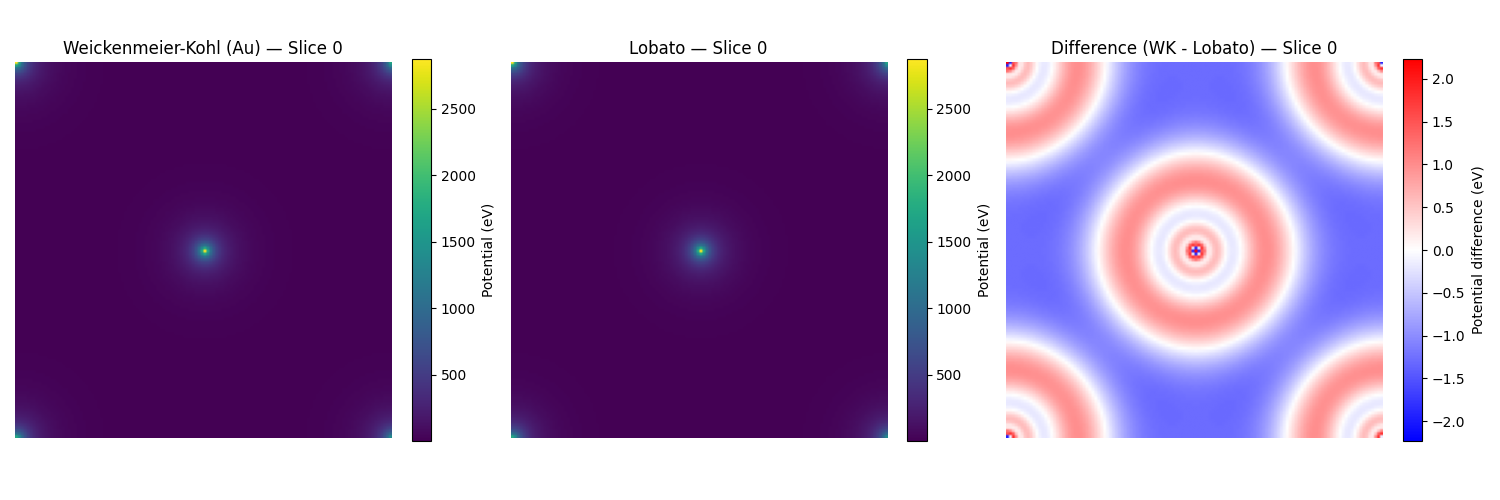

In [5]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(15, 5))

vmin = min(pot_array_wk.min(), pot_array_lobato.min())
vmax = max(pot_array_wk.max(), pot_array_lobato.max())

im0 = ax0.imshow(pot_array_wk[0], cmap='viridis', vmin=vmin, vmax=vmax)
ax0.set_title("Weickenmeier-Kohl (Au) — Slice 0")
ax0.axis("off")
fig.colorbar(im0, ax=ax0, fraction=0.046, label="Potential (eV)")

im1 = ax1.imshow(pot_array_lobato[0], cmap='viridis', vmin=vmin, vmax=vmax)
ax1.set_title("Lobato — Slice 0")
ax1.axis("off")
fig.colorbar(im1, ax=ax1, fraction=0.046, label="Potential (eV)")

diff = pot_array_wk[0] - pot_array_lobato[0]
vabs = np.max(np.abs(diff))
im2 = ax2.imshow(diff, cmap='bwr', vmin=-vabs, vmax=vabs)
ax2.set_title("Difference (WK - Lobato) — Slice 0")
ax2.axis("off")
fig.colorbar(im2, ax=ax2, fraction=0.046, label="Potential difference (eV)")

plt.tight_layout()
plt.show()

## Potential generation and probe

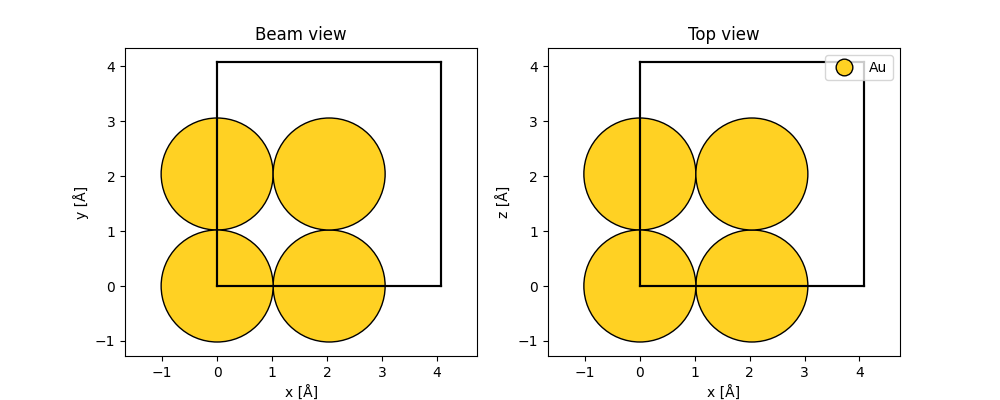

In [6]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
abtem.show_atoms(atoms, ax=ax1, title="Beam view", merge=False)
abtem.show_atoms(atoms, ax=ax2, plane="xz", title="Top view", legend=True)
plt.show()

wavelength = energy2wavelength(energy)
k0 = 2 * np.pi / wavelength

probe = abtem.PlaneWave(energy=energy)
probe.grid.match(potential_wk)
probe_array = probe.build(lazy=False).array

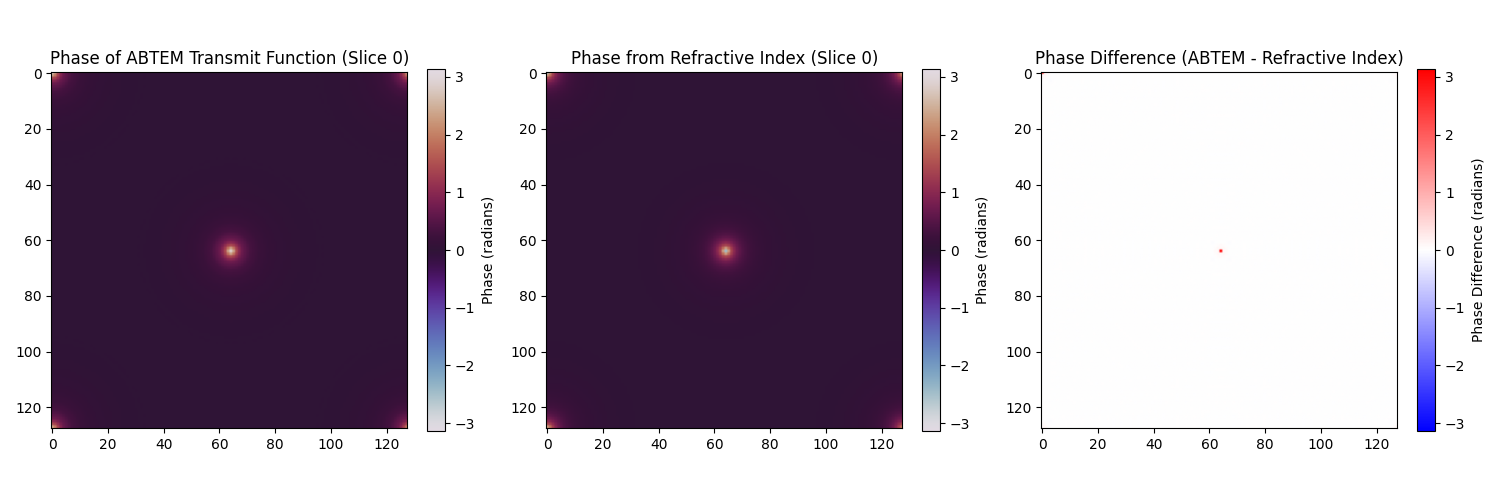

In [7]:
transmit = get_abtem_transmit(potential_lobato, energy)

transmit_0 = transmit[0]
# 1. Get the projected potential from abTEM (Units: Volt * Angstrom)
# potential_array has shape (N_slices, y, x)
V_projected = potential_lobato.build(lazy=True).array 

# 2. Get the thickness of the slice (Units: Angstrom)
dz = potential_lobato.slice_thickness[0]

# 3. Rescale to get the effective 'average' potential in Volts
# This gives us the correct magnitude to plug into the relativistic formula
V_effective = np.array(V_projected[0] / dz)

# 4. Calculate the Refractive Index (n)
# n is unitless. It depends on V_effective (Volts) and Energy (eV)
n = electron_refractive_index(V_effective, energy)

# 5. Calculate the Transmission Function
# We multiply by dz again because the electron travels through this thickness
# Units: [1] * [Angstrom] / [Angstrom] = Dimensionless (Correct)
transmission_function = jnp.exp(1j * 2 * jnp.pi * (n - 1) * dz / wavelength)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
im1 = ax1.imshow(jnp.angle(transmit_0), cmap='twilight', vmin=-jnp.pi, vmax=jnp.pi)
ax1.set_title("Phase of ABTEM Transmit Function (Slice 0)")
fig.colorbar(im1, ax=ax1, fraction=0.046, label="Phase (radians)")
im2 = ax2.imshow(jnp.angle(transmission_function), cmap='twilight', vmin=-jnp.pi, vmax=jnp.pi)
ax2.set_title("Phase from Refractive Index (Slice 0)")
fig.colorbar(im2, ax=ax2, fraction=0.046, label="Phase (radians)")

diff_phase = jnp.angle(transmit_0) - jnp.angle(transmission_function)
im3 = ax3.imshow(diff_phase, cmap='bwr', vmin=-jnp.pi, vmax=jnp.pi)
ax3.set_title("Phase Difference (ABTEM - Refractive Index)")
fig.colorbar(im3, ax=ax3, fraction=0.046, label="Phase Difference (radians)")

plt.tight_layout()
plt.show()



## WPM helper

In [8]:
transmit = get_abtem_transmit(potential_lobato, energy)

## Multislice thickness sweep (abTEM)

In [11]:
measurements_multislice = []
probe = abtem.Waves(array=probe_array, sampling=probe.sampling, energy=energy)

# Extract sampling as separate values to ensure proper type handling
sampling_x, sampling_y = probe.grid.sampling[0], probe.grid.sampling[1]

fresnel_propagator = fresnel_propagation_kernel(
    probe.grid.gpts[0],
    probe.grid.gpts[1],
    (sampling_x, sampling_y),  # Pass as tuple explicitly
    z=slice_thickness_coarse,
    energy=probe.energy,
)

measurements_ms_0_0 = []
measurements_ms_0_28 = []
for i in tqdm(n_cells_range, desc="Multislice cells"):
    if i == 0:
        exit_wave = probe.array
    else: 
        exit_wave, diffraction_pattern, _ = simulate_fresnel_as(pot_array_lobato, probe.array, fresnel_propagator, slice_thickness_coarse, energy)

    beam_0_0 = beam_amplitude_normalized(exit_wave, 0, 0, use_fftshift=True)
    beam_0_28 = beam_amplitude_normalized(exit_wave, 0, 28, use_fftshift=True)
    
    measurements_ms_0_0.append(beam_0_0)
    measurements_ms_0_28.append(beam_0_28)

    probe = abtem.Waves(array=exit_wave, sampling=probe.sampling, energy=energy)

exit_wave_ms = exit_wave
measurements_multislice = np.array(measurements_multislice)


Multislice cells:   0%|          | 0/26 [00:00<?, ?it/s]

## WPM thickness sweep

In [12]:
current_wave = probe_array

measurements_wpm_0_0 = []
measurements_wpm_0_28 = []

for i in tqdm(n_cells_range, desc="WPM cells"):
    if i == 0:
        current_wave = probe_array
        diffraction_pattern = jnp.abs(jnp.fft.fftshift(jnp.fft.fft2(current_wave) / (current_wave.shape[0] * current_wave.shape[1])))
    else:
        current_wave, diffraction_pattern, _ = simulate_wpm(
            pot_array_lobato,
            current_wave,
            slice_thickness_coarse,
            energy,
        probe.sampling,
    )

    beam_0_0 = beam_amplitude_normalized(current_wave, 0, 0, use_fftshift=True)
    beam_0_28 = beam_amplitude_normalized(current_wave, 0, 28, use_fftshift=True)

    measurements_wpm_0_0.append(beam_0_0)
    measurements_wpm_0_28.append(beam_0_28)

exit_wave_wpm = current_wave


WPM cells:   0%|          | 0/26 [00:00<?, ?it/s]

## Comparison plots

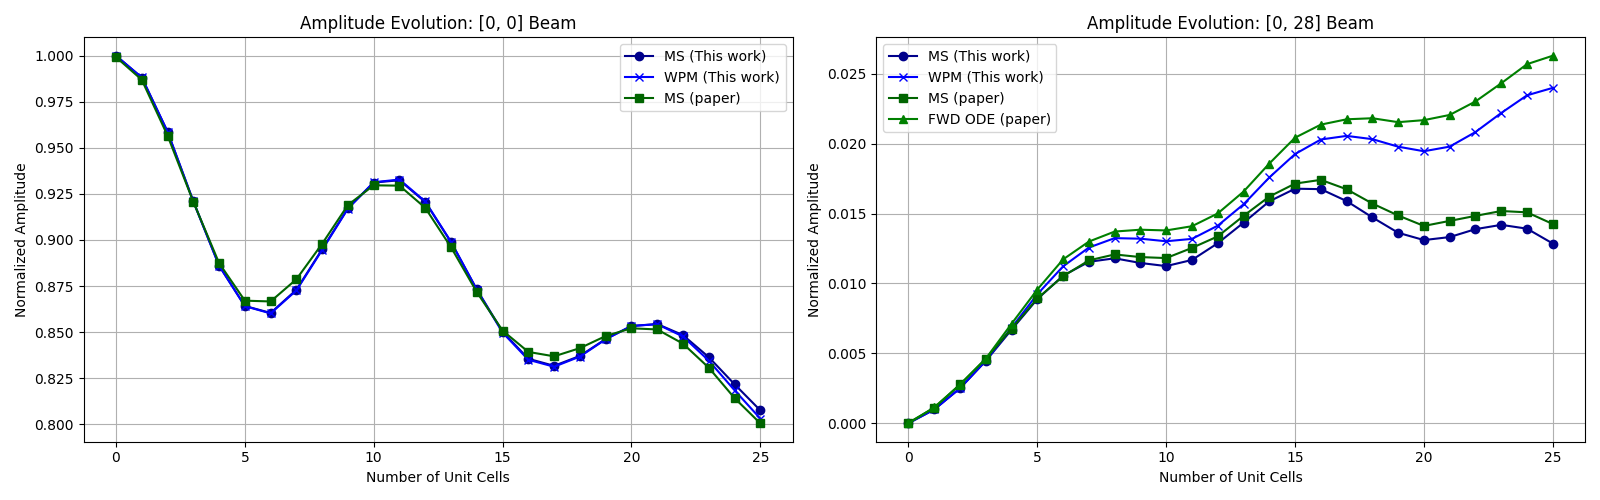

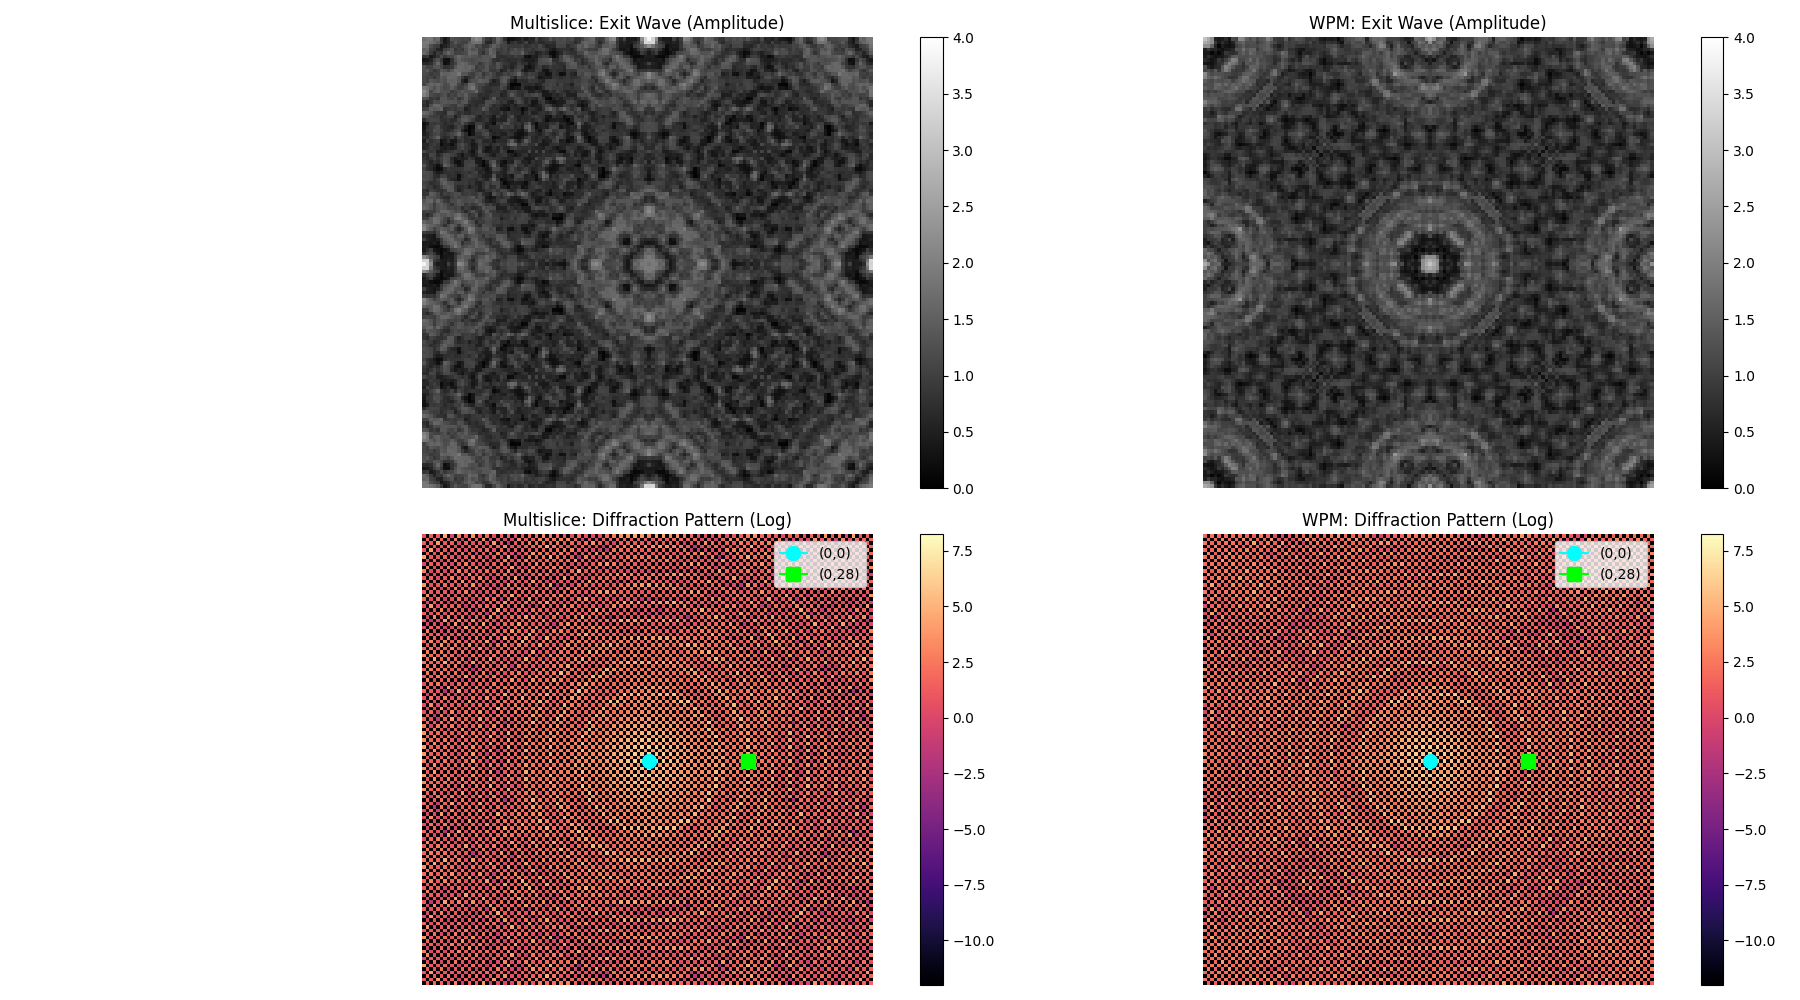

In [13]:
measurements_multislice_0_0 = np.array(measurements_ms_0_0)
measurements_multislice_paper_0_0 = Beam_0_0_Au_Klein_Gordon_MS(np.array(n_cells_range))
measurements_multislice_0_28 = np.array(measurements_ms_0_28)

measurements_fwd_ode_paper_0_28 = Beam_0_28_Au_Klein_Gordon_FWD(np.array(n_cells_range))
measurements_ms_paper_0_28 = Beam_0_28_Au_Klein_Gordon_MS(np.array(n_cells_range))
measurements_wpm_0_0 = np.array(measurements_wpm_0_0)
measurements_wpm_0_28 = np.array(measurements_wpm_0_28)

import matplotlib.patches as patches

# --- Figure 1: Beam Amplitudes ---
fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Plot [0,0] beam
ax1.plot(measurements_multislice_0_0, marker="o", label="MS (This work)", color='darkblue')
ax1.plot(measurements_wpm_0_0, marker="x", label="WPM (This work)", color='blue')
ax1.plot(measurements_multislice_paper_0_0, marker="s", label="MS (paper)", color='darkgreen')
ax1.set_xlabel("Number of Unit Cells")
ax1.set_ylabel("Normalized Amplitude")
ax1.set_title("Amplitude Evolution: [0, 0] Beam")
ax1.grid(True)
ax1.legend()

# Plot [0,28] beam
ax2.plot(measurements_multislice_0_28, marker="o", label="MS (This work)", color='darkblue')
ax2.plot(measurements_wpm_0_28, marker="x", label="WPM (This work)", color='blue')
ax2.plot(measurements_ms_paper_0_28, marker="s", label="MS (paper)", color='darkgreen')
ax2.plot(measurements_fwd_ode_paper_0_28, marker="^", label="FWD ODE (paper)", color='green')
ax2.set_xlabel("Number of Unit Cells")
ax2.set_ylabel("Normalized Amplitude")
ax2.set_title("Amplitude Evolution: [0, 28] Beam")
ax2.grid(True)
ax2.legend()

plt.tight_layout()

# --- Figure 2: Wavefields ---
fig2, axes = plt.subplots(2, 2, figsize=(18, 10))

# --- Multislice ---
ms_wave = exit_wave_ms
ms_ft = np.fft.fftshift(np.fft.fft2(ms_wave))
ms_log_int = np.log10(np.abs(ms_ft)**2 + 1e-12)

im0 = axes[0, 0].imshow(np.abs(ms_wave), cmap="gray", vmin=0, vmax=4)
axes[0, 0].set_title("Multislice: Exit Wave (Amplitude)")
axes[0, 0].axis("off")
fig2.colorbar(im0, ax=axes[0, 0], fraction=0.046)

im1 = axes[1, 0].imshow(ms_log_int, cmap="magma")
axes[1, 0].set_title("Multislice: Diffraction Pattern (Log)")
axes[1, 0].axis("off")
fig2.colorbar(im1, ax=axes[1, 0], fraction=0.046)

# Markers for (0,0) and (0,28) beams
center = 64
axes[1, 0].plot(center, center, marker='o', color='cyan', markersize=10, label='(0,0)')
axes[1, 0].plot(center + 28, center, marker='s', color='lime', markersize=10, label='(0,28)')
axes[1, 0].legend(loc='upper right')

# --- WPM ---
wpm_wave = np.array(exit_wave_wpm)
wpm_ft = np.fft.fftshift(np.fft.fft2(wpm_wave))
wpm_log_int = np.log10(np.abs(wpm_ft)**2 + 1e-12)

im2 = axes[0, 1].imshow(np.abs(wpm_wave), cmap="gray", vmin=0, vmax=4)
axes[0, 1].set_title("WPM: Exit Wave (Amplitude)")
axes[0, 1].axis("off")
fig2.colorbar(im2, ax=axes[0, 1], fraction=0.046)

im3 = axes[1, 1].imshow(wpm_log_int, cmap="magma")
axes[1, 1].set_title("WPM: Diffraction Pattern (Log)")
axes[1, 1].axis("off")
fig2.colorbar(im3, ax=axes[1, 1], fraction=0.046)

# Markers for (0,0) and (0,28) beams
axes[1, 1].plot(center, center, marker='o', color='cyan', markersize=10, label='(0,0)')
axes[1, 1].plot(center + 28, center, marker='s', color='lime', markersize=10, label='(0,28)')
axes[1, 1].legend(loc='upper right')

plt.tight_layout()


In [16]:
import numpy as np
import abtem
from ase.build import bulk
import matplotlib.pyplot as plt

# --- 1. Crystal Setup ---
atoms = bulk("Au", "fcc", a=4.08, cubic=True)

# CRITICAL FIX: The paper (Rother et al.) uses static atoms (no thermal motion).
# We must manually set the thermal spread (sigma) to 0 for all atoms.
# abTEM looks for 'thermal_sigma' in atoms.info or arrays.
atoms.info['thermal_sigma'] = 0.0 
# Depending on abTEM version, it might also check arrays, so we set it there too to be safe:
atoms.arrays['thermal_sigma'] = np.zeros(len(atoms))

# --- 2. Potential Setup ---
# The paper uses a 128x128x128 grid for one unit cell[cite: 556].
# Since we have 25 cells thickness, we set up the slice thickness to match layers.
coarse_unitcell_gpts = (128, 128) 
cell_thickness = atoms.cell[2, 2]
slice_thickness = cell_thickness / 2  # 2 atomic planes per cubic cell

# Use your Custom WK Parametrization (ensure the class from previous steps is defined)
# If using standard lobato for comparison, ensure thermal_sigma=0 is respected.
potential = abtem.Potential(
    atoms,
    gpts=coarse_unitcell_gpts,
    slice_thickness=slice_thickness,
    projection="infinite",
    parametrization='lobato' # Use the `wk_param` instance you created earlier
)

# --- 3. Multislice Simulation ---
# Setup the incoming plane wave (300 kV as per paper)
wave = abtem.PlaneWave(energy=300e3)

# Define the potential for exactly one unit cell.
# Since we defined slice_thickness = cell_thickness / 2, 
# one unit cell corresponds to exactly 2 slices.
unit_cell_potential = potential[:2]

# We want to track the evolution over 25 unit cells
n_unit_cells = 25

exit_waves = []

# Run multislice step-by-step
for i in range(n_unit_cells):
    # Propagate the current wave through the unit cell potential
    # The result is the new wave for the next step.
    wave = wave.multislice(unit_cell_potential)
    
    # Store the result (using .copy() to ensure we save the state at this step)
    exit_waves.append(wave.copy())

# --- 4. Extract Beam Amplitudes ---
# We need the amplitude of the (0, 28, 0) beam.
# Stack waves to shape (Thickness, y, x)
stack = abtem.stack(exit_waves)

# Calculate diffraction patterns (Fourier transform)
diffraction = stack.diffraction_patterns()

# Extract the specific beam: (h, k) = (0, 28)
# abTEM usually centers the zero beam. We can use `get_intensities` with specific points
# or simply crop if we know the pixel index.
# Better method: Masking specific spots.
beam_amplitude = []

# Calculate the precise scattering angle for (0, 28, 0) to confirm index
# g = 28 / 4.08 = 6.86 A^-1. alpha = lambda * g ~ 135 mrad.
# This is a very high angle, ensure it is within the bandwidth (g_max ~ 15 A^-1 for 128 px).
# It is within range.

for wave_slice in stack:
    # Get complex diffraction pattern
    # shift=True puts (0,0) in center.
    fft = np.fft.fftshift(np.fft.fft2(wave_slice.array))
    
    # Find the index of (0, 28). 
    # Grid is 128x128. Center is (64, 64).
    # In reciprocal pixels, 1 unit of h/k is 1 pixel because we simulated exactly 1 unit cell in XY.
    # Therefore (0, 28) is at index (64 + 0, 64 + 28) = (64, 92)
    # Note: Indices might be (y, x) -> (k, h).
    
    amp = np.abs(fft[64, 64 + 28]) # Check (k=28, h=0)
    
    # Normalize by total number of pixels to get amplitude comparable to paper
    # (Normalization conventions vary, paper max is ~0.025)
    norm_amp = amp / (128 * 128)
    beam_amplitude.append(norm_amp)


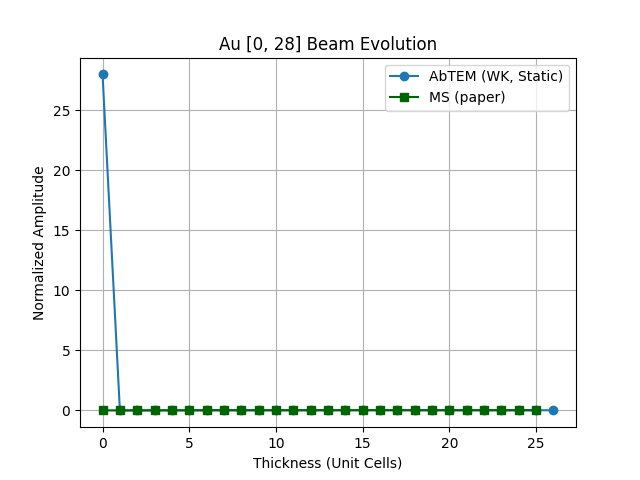

In [18]:
beam_amplitude = np.array(beam_amplitude)
beam_amplitude = np.insert(beam_amplitude, 0, 28)  # Prepend zero-order beam (thickness 0)
# --- 5. Plotting ---
plt.figure()
plt.plot(beam_amplitude, marker='o', label='AbTEM (WK, Static)')
plt.plot(measurements_ms_paper_0_28, marker="s", label="MS (paper)", color='darkgreen')
plt.xlabel('Thickness (Unit Cells)')
plt.ylabel('Normalized Amplitude')
plt.title('Au [0, 28] Beam Evolution')
plt.grid(True)
plt.legend()
plt.show()

## Bloch-wave (abTEM) reference
This runs a Bloch-wave simulation at the same beam conditions and plots the full diffraction intensity.
The helper looks for the Bloch-wave API across abTEM versions.


100%|██████████| 25/25 [04:12<00:00, 10.12s/it]


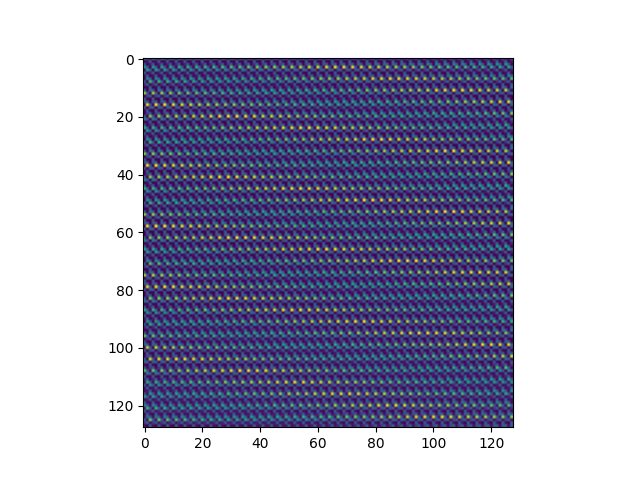

In [14]:
from abtem.bloch import BlochWaves, StructureFactor
from tqdm import tqdm, trange

g_max = 50.0

structure_factor = StructureFactor(
    atoms,
    g_max=g_max, 
    parametrization='lobato',
    device='gpu'
)

# Initialize BlochWaves
# sg_max controls how many beams are included based on excitation error
bloch_waves = BlochWaves(
    structure_factor=structure_factor,
    energy=energy,
    sg_max=0.1, # 1/A
)

# Define thicknesses for comparison (0 to 25 unit cells)
# MS simulation did 25 steps, recording each step. + initial wave (0 thickness).
# Length of beam_amplitude in MS part was 26.
thicknesses = np.arange(25) * atoms.cell[2, 2]

# Calculate Exit Waves (real space)
exit_waves_bloch = [bloch_waves.calculate_exit_waves(thickness, gpts=(128, 128), g_max=g_max) for thickness in thicknesses]

# Calculate Diffraction Patterns (reciprocal space) via FFT
amplitude_0_0 = []
amplitude_0_28 = []

for wave_func in tqdm(exit_waves_bloch):
    # Get the wave array (may be on GPU/device)
    psi = wave_func.array
    psi = psi.compute()
    psi = jnp.array(psi)  # Ensure it's a numpy array for processing

    # beam_amplitude_normalized is defined in cell 2
    # Ensure inputs are appropriate (psi is 128x128)
    amp0 = beam_amplitude_normalized(psi, 0, 0, use_fftshift=True)
    amp28 = beam_amplitude_normalized(psi, 0, 28, use_fftshift=True)
    
    amplitude_0_0.append(amp0)
    amplitude_0_28.append(amp28)

plt.figure()
plt.imshow(np.abs(psi)**2)

# Convert to numpy for plotting
amplitude_0_0 = np.array(amplitude_0_0)
amplitude_0_28 = np.array(amplitude_0_28)


In [ ]:

# # Plot Comparison
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# # Plot [0,0] beam
# ax1.plot(thicknesses / atoms.cell[2, 2], amplitude_0_0, label='Bloch Waves (0,0)', linewidth=2)
# # Check if MS result exists
# if 'measurements_multislice_0_0' in locals():
#     ax1.plot(measurements_multislice_0_0, 'o', label='Multislice (0,0)', alpha=0.5)

# ax1.set_xlabel('Thickness (Unit Cells)')
# ax1.set_ylabel('Normalized Amplitude')
# ax1.set_title('Au (0, 0) Beam Amplitude')
# ax1.legend()
# ax1.grid(True)

# # Plot [0,28] beam
# ax2.plot(thicknesses / atoms.cell[2, 2], amplitude_0_28, label='Bloch Waves (0,28)', linewidth=2)
# # Check if MS result exists
# if 'measurements_multislice_0_28' in locals():
#     ax2.plot(measurements_multislice_0_28, 'o', label='Multislice (0,28)', alpha=0.5)
# # Check if Paper result exists
# if 'measurements_ms_paper_0_28' in locals():
#     ax2.plot(measurements_ms_paper_0_28, 's', label='Paper Ref (0,28)', fillstyle='none')

# ax2.set_xlabel('Thickness (Unit Cells)')
# ax2.set_ylabel('Normalized Amplitude')
# ax2.set_title('Au (0, 28) Beam Amplitude')
# ax2.legend()
# ax2.grid(True)

# plt.show()

In [ ]:
# bloch_jax_abtemlike.py
from __future__ import annotations
from dataclasses import dataclass
from functools import partial
from typing import Tuple

import numpy as np
import jax
import jax.numpy as jnp

# ----------------------------
# Lobato scattering factor (same algebra as abTEM lobato.scattering_factor)
# f(k^2) = Σ_i a_i * (2 + b_i k^2) / (1 + b_i k^2)^2
# See abTEM source: abtem.parametrizations.functions.lobato.scattering_factor :contentReference[oaicite:5]{index=5}
# ----------------------------
@jax.jit
def lobato_scattering_factor_k2(k2: jnp.ndarray, a: jnp.ndarray, b: jnp.ndarray) -> jnp.ndarray:
    # k2: (...,)
    # a,b: (...,5) broadcastable with k2[...,None]
    k2e = k2[..., None]
    return jnp.sum(a * (2.0 + b * k2e) / (1.0 + b * k2e) ** 2, axis=-1)


# ----------------------------
# Build structure factors F(h,k) on a beam list (pure JAX, jittable)
# ----------------------------
@jax.jit
def structure_factors_xy(
    hk: jnp.ndarray,          # (Ng,2) int32
    frac_xy: jnp.ndarray,     # (Na,2) float
    Z: jnp.ndarray,           # (Na,) int32
    g_vec: jnp.ndarray,       # (Ng,3) float
    a_table: jnp.ndarray,     # (Zmax+1,5) float
    b_table: jnp.ndarray,     # (Zmax+1,5) float
    volume: jnp.ndarray,      # () float
) -> jnp.ndarray:
    # k2 = |g|^2 for each (h,k)
    k2 = jnp.sum(g_vec * g_vec, axis=1)  # (Ng,)

    # per-atom a,b
    a = a_table[Z]  # (Na,5)
    b = b_table[Z]  # (Na,5)

    # f_e(g^2, Z): (Ng,Na)
    f = lobato_scattering_factor_k2(k2[:, None], a[None, :, :], b[None, :, :])

    # exp(2π i (h x + k y)) using fractional coords, consistent with abTEM structure factor phase :contentReference[oaicite:6]{index=6}
    phase = jnp.exp(2j * jnp.pi * (hk[:, 0:1] * frac_xy[None, :, 0] + hk[:, 1:2] * frac_xy[None, :, 1]))

    F = jnp.sum(f * phase, axis=1)

    # abTEM divides structure factors by cell volume :contentReference[oaicite:7]{index=7}
    return F / volume


# ----------------------------
# Small helpers for static-shape FFT scatter
# ----------------------------
def make_exit_waves_from_coeffs_fft(nx: int, ny: int, hk_sel: np.ndarray):
    hk_sel_j = jnp.array(hk_sel.astype(np.int32))
    hx = jnp.mod(hk_sel_j[:, 0], nx).astype(jnp.int32)
    ky = jnp.mod(hk_sel_j[:, 1], ny).astype(jnp.int32)

    @partial(jax.jit)
    def one(C):
        grid = jnp.zeros((nx, ny), dtype=C.dtype)
        grid = grid.at[hx, ky].add(C)
        return jnp.fft.ifft2(grid)

    @partial(jax.jit)
    def batched(Ct):
        return jax.vmap(one)(Ct)

    return one, batched


@dataclass
class BlochSystem:
    # Beam list
    hk_sel: jnp.ndarray      # (N,2) int32
    g_vec_sel: jnp.ndarray   # (N,3) float
    wavelength: float

    # Eigen-decomposition
    evals: jnp.ndarray       # (N,)
    evecs: jnp.ndarray       # (N,N)

    # Precomputed for fast thickness evaluation
    gamma: jnp.ndarray       # (N,)
    alpha0: jnp.ndarray      # (N,)  == C^H @ psi0

    # Index of (0,0) beam in hk_sel
    idx_000: int


@partial(jax.jit)
def coefficients_at_thickness(thicknesses: jnp.ndarray, evecs: jnp.ndarray, gamma: jnp.ndarray, alpha0: jnp.ndarray) -> jnp.ndarray:
    # thicknesses: (T,)
    # returns Ct: (T,N)
    def one_t(t):
        ph = jnp.exp(2j * jnp.pi * t * gamma)  # matches abTEM propagation :contentReference[oaicite:8]{index=8}
        return evecs @ (ph * alpha0)
    return jax.vmap(one_t)(thicknesses)


def build_bloch_system_lobato_abtemlike(
    atoms,
    energy_eV: float,
    g_max: float,
    sg_max: float,
    gpts_exit: Tuple[int, int] = (128, 128),
    correct: bool = True,
    dtype_complex=jnp.complex128,
):
    """
    Build once, then evaluate Ct(t) fast for any thickness array.
    Uses abTEM's convention for prefactor/diag/projection IF you import the same constants (below).

    You MUST supply Lobato (a,b) parameter tables. The easiest way is to steal them from abTEM itself
    (see section 3).
    """

    # ---- host-side beam enumeration (static lists) ----
    # Use ASE reciprocal like abTEM does: g_vec = hkl @ cell.reciprocal() :contentReference[oaicite:9]{index=9}
    recip = np.array(atoms.cell.reciprocal(), float)  # (3,3)
    vol = float(atoms.cell.volume)

    # enumerate hk within g_max using |g| from g_vec length
    # crude bounds
    dg = np.linalg.norm(recip[:2, :2], axis=1)
    H = int(np.ceil(g_max / max(dg[0], 1e-12)))
    K = int(np.ceil(g_max / max(dg[1], 1e-12)))

    hk_all = []
    g_all = []
    for h in range(-H, H + 1):
        for k in range(-K, K + 1):
            hkl = np.array([h, k, 0], int)
            gv = hkl @ recip
            if np.linalg.norm(gv) <= g_max + 1e-12:
                hk_all.append((h, k))
                g_all.append(gv)
    hk_all = np.array(hk_all, np.int32)
    g_all = np.array(g_all, float)

    # ensure (0,0) is first
    z = np.where((hk_all[:, 0] == 0) & (hk_all[:, 1] == 0))[0]
    if len(z) == 1 and z[0] != 0:
        hk_all[[0, z[0]]] = hk_all[[z[0], 0]]
        g_all[[0, z[0]]] = g_all[[z[0], 0]]

    # ---- abTEM energy constants for matching conventions (see section 3) ----
    from abtem.core.energy import energy2sigma, energy2wavelength
    from abtem.core.constants import kappa

    wavelength = float(energy2wavelength(energy_eV))
    prefactor = float(energy2sigma(energy_eV) / wavelength / np.pi / kappa)  # :contentReference[oaicite:10]{index=10}

    # excitation errors sg = (2*g_z - wavelength*|g|^2)/2 :contentReference[oaicite:11]{index=11}
    sg_all = (2.0 * g_all[:, 2] - wavelength * np.sum(g_all * g_all, axis=1)) / 2.0

    # select beams by sg_max and also keep (0,0)
    keep = np.where(np.abs(sg_all) <= sg_max + 1e-12)[0]
    if 0 not in keep:
        keep = np.concatenate([np.array([0], int), keep])
    keep = np.unique(keep)

    hk_sel = hk_all[keep]
    g_sel = g_all[keep]
    sg_sel = sg_all[keep]

    # index of (0,0)
    idx_000 = int(np.where((hk_sel[:, 0] == 0) & (hk_sel[:, 1] == 0))[0][0])

    # ---- Lobato parameter tables from abTEM (scaled parameters) ----
    # This gives you the same parameters abTEM uses for scattering_factor(Z)(g^2) :contentReference[oaicite:12]{index=12}
    from abtem.parametrizations import LobatoParametrization
    from ase.data import chemical_symbols

    Zs = np.array(atoms.get_atomic_numbers(), np.int32)
    Zmax = int(Zs.max())
    a_table = np.zeros((Zmax + 1, 5), np.float32)
    b_table = np.zeros((Zmax + 1, 5), np.float32)

    lob = LobatoParametrization()
    for Z in np.unique(Zs):
        sym = chemical_symbols[int(Z)]
        p = lob.scaled_parameters(sym, "scattering_factor")  # shape (2,5)
        a_table[int(Z)] = np.array(p[0], np.float32)
        b_table[int(Z)] = np.array(p[1], np.float32)

    # ---- JAX arrays ----
    hk_all_j = jnp.array(hk_all, dtype=jnp.int32)
    hk_sel_j = jnp.array(hk_sel, dtype=jnp.int32)
    g_all_j = jnp.array(g_all, dtype=jnp.float64)
    g_sel_j = jnp.array(g_sel, dtype=jnp.float64)

    frac = np.array(atoms.get_scaled_positions(), float)
    frac_xy_j = jnp.array(frac[:, :2], dtype=jnp.float64)
    Z_j = jnp.array(Zs, dtype=jnp.int32)

    a_table_j = jnp.array(a_table, dtype=jnp.float64)
    b_table_j = jnp.array(b_table, dtype=jnp.float64)
    vol_j = jnp.array(vol, dtype=jnp.float64)

    # ---- structure factors on hk_all ----
    F_all = structure_factors_xy(hk_all_j, frac_xy_j, Z_j, g_all_j, a_table_j, b_table_j, vol_j).astype(dtype_complex)

    # ---- build U matrix by indexing F(Δh,Δk) ----
    # Make a dense lookup grid Fgrid[h+H,k+K] (H,K are Python ints => static shapes if you jit this inside a closure)
    Hs = int(np.max(np.abs(hk_all[:, 0])))
    Ks = int(np.max(np.abs(hk_all[:, 1])))

    @partial(jax.jit)
    def make_Fgrid(hk, F):
        grid = jnp.zeros((2 * Hs + 1, 2 * Ks + 1), dtype=F.dtype)
        return grid.at[hk[:, 0] + Hs, hk[:, 1] + Ks].add(F)

    Fgrid = make_Fgrid(hk_all_j, F_all)

    # Δh, Δk for selected beams
    dh = hk_sel_j[:, 0:1] - hk_sel_j[None, :, 0]  # (N,N)
    dk = hk_sel_j[:, 1:2] - hk_sel_j[None, :, 1]  # (N,N)

    # gather F(Δh,Δk)
    U = prefactor * Fgrid[dh + Hs, dk + Ks]  # (N,N), matches abTEM coupling lookup :contentReference[oaicite:13]{index=13}

    # diagonal term diag = 2/wavelength * sg :contentReference[oaicite:14]{index=14}
    sg_sel_j = jnp.array(sg_sel, dtype=jnp.float64)
    diag = (2.0 / wavelength) * sg_sel_j

    if correct:
        # same correction factors as abTEM :contentReference[oaicite:15]{index=15}
        corr = jnp.sqrt(1.0 + wavelength * g_sel_j[:, 2])
        U = U / (corr[:, None] * corr[None, :])
        diag = diag / (1.0 + wavelength * g_sel_j[:, 2])

    U = U.at[jnp.diag_indices(U.shape[0])].set(diag.astype(U.real.dtype))

    # Hermitian eigendecomposition (abTEM uses eigh) :contentReference[oaicite:16]{index=16}
    evals, evecs = jnp.linalg.eigh(U)

    gamma = evals * (wavelength / 2.0)  # :contentReference[oaicite:17]{index=17}

    # Incident plane wave: 1 at (0,0)
    N = hk_sel.shape[0]
    psi0 = jnp.zeros((N,), dtype=dtype_complex).at[idx_000].set(1.0 + 0.0j)

    # abTEM uses C_inv = C^H 
    alpha0 = jnp.conjugate(evecs.T) @ psi0

    # optional extra correction to eigenvectors like abTEM does after eigh 
    if correct:
        corr = jnp.sqrt(1.0 + wavelength * g_sel_j[:, 2])
        evecs = evecs / corr[:, None]
        # alpha0 should be recomputed with corrected evecs
        alpha0 = jnp.conjugate(evecs.T) @ psi0

    sys = BlochSystem(
        hk_sel=hk_sel_j,
        g_vec_sel=g_sel_j,
        wavelength=wavelength,
        evals=evals,
        evecs=evecs,
        gamma=gamma,
        alpha0=alpha0,
        idx_000=idx_000,
    )

    # attach FFT helpers (static gpts)
    nx, ny = map(int, gpts_exit)
    one_exit, batched_exit = make_exit_waves_from_coeffs_fft(nx, ny, hk_sel)
    return sys, one_exit, batched_exit


In [ ]:
from tqdm import tqdm
import numpy as np
import jax.numpy as jnp

sys, one_exit, batched_exit = build_bloch_system_lobato_abtemlike(
    atoms=atoms,
    energy_eV=energy,
    g_max=100.0,
    sg_max=2.0,
    gpts_exit=(128, 128),
    correct=True
)

thicknesses = jnp.array(np.arange(25) * atoms.cell[2, 2], dtype=jnp.float64)

# Coefficients at all thicknesses (T,N) -- THIS is the cheap part after the solve
Ct = coefficients_at_thickness(thicknesses, sys.evecs, sys.gamma, sys.alpha0)

# If you also want real-space exit waves:
exit_waves = batched_exit(Ct)  # (T,128,128) complex


In [ ]:
amplitude_0_0_bloch = []
amplitude_0_28_bloch = []

for wave_func in tqdm(exit_waves):
    psi = wave_func
    amp0 = beam_amplitude_normalized(psi, 0, 0, use_fftshift=True)
    amp28 = beam_amplitude_normalized(psi, 0, 28, use_fftshift=True)
    
    amplitude_0_0_bloch.append(amp0)
    amplitude_0_28_bloch.append(amp28)

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 135.12it/s]


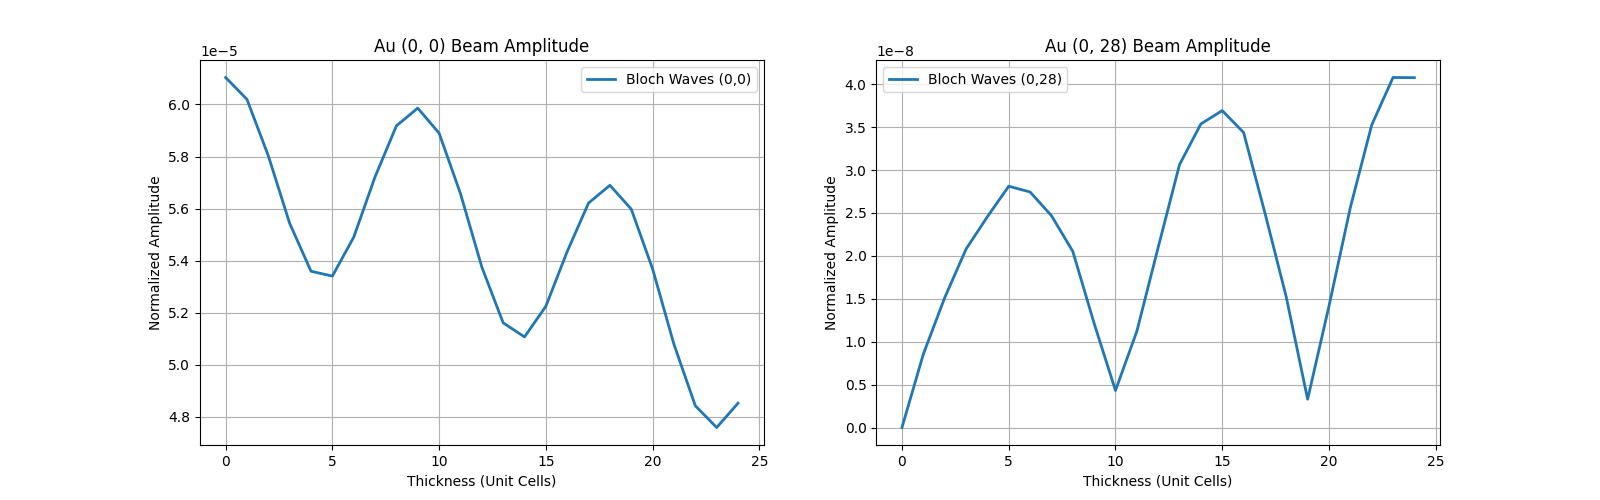

In [ ]:
# Plot Comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Plot [0,0] beam
ax1.plot(thicknesses / atoms.cell[2, 2], amplitude_0_0_bloch, label='Bloch Waves (0,0)', linewidth=2)
# # Check if MS result exists
# if 'measurements_multislice_0_0' in locals():
#     ax1.plot(measurements_multislice_0_0, 'o', label='Multislice (0,0)', alpha=0.5)

ax1.set_xlabel('Thickness (Unit Cells)')
ax1.set_ylabel('Normalized Amplitude')
ax1.set_title('Au (0, 0) Beam Amplitude')
ax1.legend()
ax1.grid(True)

# Plot [0,28] beam
ax2.plot(thicknesses / atoms.cell[2, 2], amplitude_0_28_bloch, label='Bloch Waves (0,28)', linewidth=2)
# # Check if MS result exists
# if 'measurements_multislice_0_28' in locals():
#     ax2.plot(measurements_multislice_0_28, 'o', label='Multislice (0,28)', alpha=0.5)
# # Check if Paper result exists
# if 'measurements_ms_paper_0_28' in locals():
#     ax2.plot(measurements_ms_paper_0_28, 's', label='Paper Ref (0,28)', fillstyle='none')

ax2.set_xlabel('Thickness (Unit Cells)')
ax2.set_ylabel('Normalized Amplitude')
ax2.set_title('Au (0, 28) Beam Amplitude')
ax2.legend()
ax2.grid(True)

plt.show()
